# CIR Model and cash vs ZC bonds

The Cox Ingersoll Ross model gives the changes in the interest rate at time t based on mean reversion of observed and long-term rates combined with a random measure tied to the volatility. It is an extension of the Vasicek model.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from my_modules import risk
from my_modules import data
from my_modules import portfolio
from my_modules import index
from my_modules import model

import numpy as np
import pandas as pd

In [11]:
## Short rate (instantaneous rate, e.g. a day) vs Annualised
# If we're compunding every 1/N of a year (i.e. n times per year), the annualised rate is = (1 + r/N)^N
# With very large values of N: 1 + annual_r = e^instant_r, i.e. instant_r = ln(1 + annual_r)

def inst_to_ann(r):
    """
    Converts short rate to an annualised rate
    """
    return np.expm1(r) # == np.exp(r) - 1

def ann_to_inst(r):
    """
    Converts annualised rate to short rate
    """
    return np.log1p(r) # == np.log(1 + r)

### CIR
$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

In [20]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Gives the change in interest rate according to the Cox Ingersoll Ross model.
    """
    if r_0 is None: r_0=b
    r_0 = ann_to_inst(r_0) #For small values of r the instantaneosu rate is not that different to the annual
    dt = 1/steps_per_year
    
    #dWt part requires random numbers, referred to as the shock
    num_steps = int(n_years * steps_per_year)
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        rt = rates[step - 1]
        d_r_t = a * (b - rt) + sigma*np.sqrt(rt)*shock[step]
        rates[step] = abs(rt + d_r_t) #This should be a positive number but to be safe with rouding errors/high shocks abs
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

In [4]:
%matplotlib inline

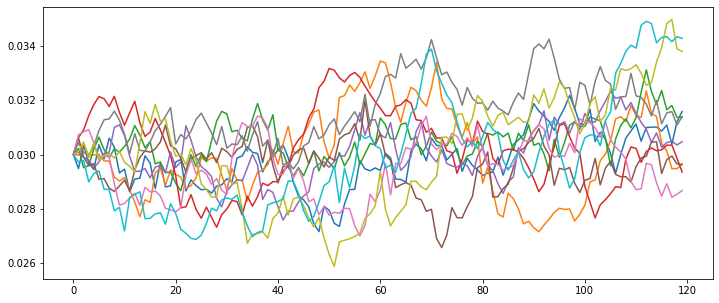

In [24]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,5), legend=False)